# Research Supervisor

*The supervisor has a simple job: delegate research tasks to an appropriate number of sub-agents.*

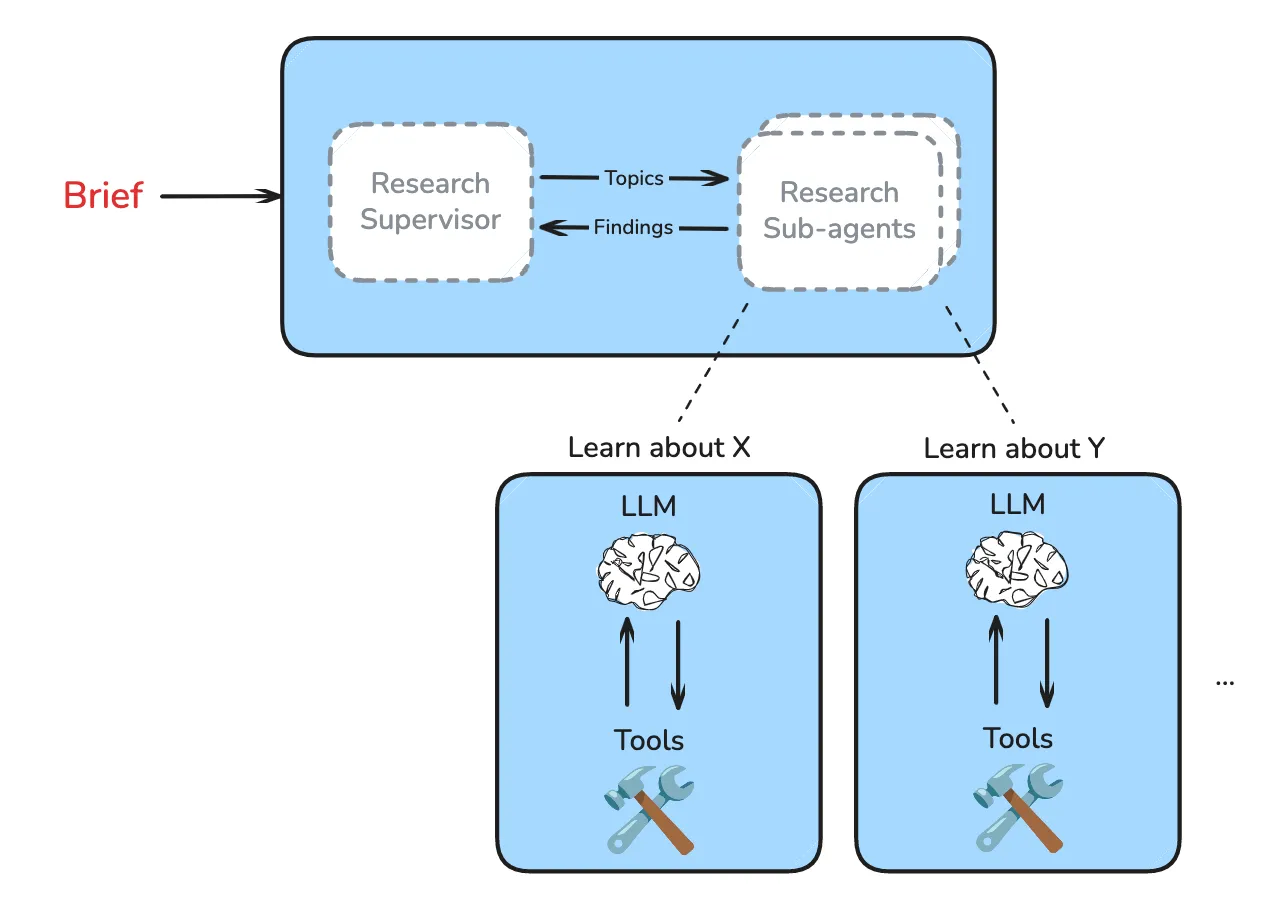

## The Case for Multi-Agent Research Systems

We previously built a research agent bound to either custom tools or MCP server. Now, what happens if the request is complex and has several sub-topics? 

Single agent response quality *can* suffer wuth multiple sub-topics (e.g., compare A to B to C) because a single context window needs to store and reason about tool feedback across all of the sub-topics. 

[Numerous failure modes](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), such as [context clash](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), become prevalent as the context window accumulates tool calls across many different sub-topics. As discussed in [Anthropic's blog post](https://www.anthropic.com/engineering/built-multi-agent-research-system), multi-agent systems can split sub-topic to sub-agents with isolated context windows.

## Supervisor Architecture

The supervisor determines if the research brief can be broken-down into independent sub-topics and delegates to sub-agents with isolated context windows. 

### Prompt

First, we'll define a prompt that instructs our agent to use available search tools. 

In [1]:
from rich.markdown import Markdown
from deep_research_from_scratch.prompts import lead_researcher_prompt
Markdown(lead_researcher_prompt)

Your job is to conduct research by calling the "ConductResearch" tool. For context, today's date is {date}.        




Parallel research saves the user time, but reason carefully about when you should use it                           

 • Calling the "ConductResearch" tool multiple times in parallel can save the user time.                           
 • You should only call the "ConductResearch" tool multiple times in parallel if the different topics that you are 
   researching can be researched independently in parallel with respect to the user's overall question.            
 • This can be particularly helpful if the user is asking for a comparison of X and Y, if the user is asking for a 
   list of entities that each can be researched independently, or if the user is asking for multiple perspectives  
   on a topic.                                                                                                     
 • Each research agent needs to be provided all of the context that is necessary to focus on a sub-topic.          
 • Do not call the "ConductResearch" tool more than {max_concurrent_research_units} times at once. This limit is   
   enforced by the user. It is perfectly fine, and expected, that you return less than this number of tool calls.  
 • If you are not confident in how you can parallelize research, you can call the "ConductResearch" tool once in   
   order to gather more background information, so you have more context to reason about if it's necessary to      
   parallelize research.                                                                                           

Different questions require different levels of research depth                                                     

 • If a user is asking a broader question, your research can be more shallow, and you may not need to iterate and  
   call the "ConductResearch" tool as many times.                                                                  
 • If a user uses terms like "detailed" or "comprehensive" in their question, you may need to be more stingy about 
   the depth of your findings, and you may need to iterate and call the "ConductResearch" tool more times to get a 
   fully detailed answer.                                                                                          

Research is expensive                                                                                              

 • Research is expensive, both from a monetary and time perspective.                                               
 • As you look at your history of tool calls, as you have conducted more and more research, the theoretical        
   "threshold" for additional research should be higher.                                                           
 • In other words, as the amount of research conducted grows, be more stingy about making even more follow-up      
   "ConductResearch" tool calls, and more willing to call "ResearchComplete" if you are satisfied with the research
   findings.                                                                                                       
 • You should only ask for topics that are ABSOLUTELY necessary to research for a comprehensive answer.            
 • Before you ask about a topic, be sure that it is substantially different from any topics that you have already  
   researched. It needs to be substantially different, not just rephrased or slightly different. The researchers   
   are quite comprehensive, so they will not miss anything.                                                        
 • When you call the "ConductResearch" tool, make sure to explicitly state how much effort you want the sub-agent  
   to put into the research. For background research, you may want it to be a shallow or small effort. For critical
   topics, you may want it to be a deep or large effort. Make the effort level explicit to the researcher.         
   </Important Guidelines>                     

### State

In [2]:
%%writefile ../src/deep_research_from_scratch/multi_agent_supervisor_state.py

# TODO: Add comment and improve formatting, but don't modify the code 

import operator
from typing import Annotated, TypedDict

from pydantic import BaseModel, Field
from langchain_core.messages import MessageLikeRepresentation

def override_reducer(current_value, new_value):
    if isinstance(new_value, dict) and new_value.get("type") == "override":
        return new_value.get("value", new_value)
    else:
        return operator.add(current_value, new_value)

class SupervisorState(TypedDict):
    supervisor_messages: Annotated[list[MessageLikeRepresentation], operator.add]
    research_brief: str
    notes: Annotated[list[str], override_reducer] = []
    research_iterations: int = 0
    raw_notes: Annotated[list[str], override_reducer] = []

class ResearcherState(TypedDict):
    researcher_messages: Annotated[list[MessageLikeRepresentation], operator.add]
    tool_call_iterations: int = 0
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[list[str], override_reducer] = []

class ResearcherOutputState(BaseModel):
    compressed_research: str
    raw_notes: Annotated[list[str], override_reducer] = []

class ConductResearch(BaseModel):
    """Call this tool to conduct research on a specific topic."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

class ResearchComplete(BaseModel):
    """Call this tool to indicate that the research is complete."""

Overwriting ../src/deep_research_from_scratch/multi_agent_supervisor_state.py


### Multi-agent 

Now, we'll define our agent.

In [34]:
%%writefile ../src/deep_research_from_scratch/multi_agent_supervisor.py

"""
Multi-Agent Research Supervisor System

This module implements a multi-agent research system where a supervisor coordinates
multiple research agents to conduct parallel research on different topics.

Architecture:
- Supervisor: Decides what research to conduct and when to complete
- Researcher Subgraph: Individual research agents that perform tool calls
- State Management: Tracks conversation history and research progress
"""

import asyncio
from datetime import datetime
from typing_extensions import Literal

import nest_asyncio
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, MessageLikeRepresentation, filter_messages, SystemMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.utils import tavily_search
from deep_research_from_scratch.prompts import research_agent_prompt, compress_research_system_prompt
from deep_research_from_scratch.multi_agent_supervisor_state import SupervisorState, ResearcherState, ResearcherOutputState, ConductResearch, ResearchComplete

# ===== UTILITY FUNCTIONS =====

def get_notes_from_tool_calls(messages: list[MessageLikeRepresentation]) -> list[str]:
    """Extract content from tool messages in the conversation history."""
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

# ===== CONFIGURATION =====

# Enable nested event loops for Jupyter
nest_asyncio.apply()

# Initialize researcher model and tools
researcher_tools = [tavily_search]
researcher_tools_by_name = {tool.name: tool for tool in researcher_tools}
researcher_model = init_chat_model(model="openai:gpt-4.1")
researcher_model_with_tools = researcher_model.bind_tools(researcher_tools)

# Initialize supervisor model and tools
supervisor_tools = [ConductResearch, ResearchComplete]
supervisor_model = init_chat_model(model="openai:gpt-4.1")
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# System constants
max_researcher_iterations = 3

# ===== RESEARCHER NODES =====

def researcher_llm_call(state: ResearcherState) -> Command[Literal["researcher_tool_node"]]:
    """
    Researcher LLM decision node.
    
    The researcher decides whether to call tools based on the current conversation state.
    Always proceeds to tool execution to maintain the research flow.
    """
    result = researcher_model_with_tools.invoke(
        [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
    )
    
    return Command(
        goto="researcher_tool_node",
        update={
            "researcher_messages": [result],
            "tool_call_iterations": state.get("tool_call_iterations", 0) + 1
        }
    )

def researcher_tool_node(state: ResearcherState) -> Command[Literal["compress_research", "researcher_llm_call"]]:
    """
    Researcher tool execution node.
    
    Executes tool calls concurrently and decides whether to continue research
    or proceed to compression based on iteration limits.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
    
    async def execute_tools():
        """Execute all tool calls concurrently for better performance."""
        coros = []
        for tool_call in tool_calls:
            tool = researcher_tools_by_name[tool_call["name"]]
            coros.append(tool.ainvoke(tool_call["args"]))
        
        # Execute all tool calls concurrently
        observations = await asyncio.gather(*coros)
        
        # Create tool message outputs
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            ) for observation, tool_call in zip(observations, tool_calls)
        ]
        
        return tool_outputs
    
    # Run async function in sync context with nested event loop support
    tool_outputs = asyncio.run(execute_tools())

    # Determine next step: compress if max iterations reached or continue research
    should_compress = (
        state.get("tool_call_iterations", 0) >= max_researcher_iterations or 
        any(tool_call["name"] == "ResearchComplete" for tool_call in tool_calls)
    )
    
    if should_compress:
        return Command(
            goto="compress_research",
            update={"researcher_messages": tool_outputs}
        )
    
    return Command(
        goto="researcher_llm_call",
        update={"researcher_messages": tool_outputs}
    )

async def compress_research(state: ResearcherState):
    """
    Research compression node.
    
    Summarizes and compresses the research findings into a concise report
    while preserving all raw notes for reference.
    """
    response = await researcher_model.ainvoke([
        SystemMessage(content=compress_research_system_prompt.format(date=get_today_str())),
        *state.get("researcher_messages", [])
    ])
    
    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join([
            str(m.content) for m in filter_messages(
                state["researcher_messages"], 
                include_types=["tool", "ai"]
            )
        ])]
    }

# ===== SUPERVISOR NODES =====

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """
    Supervisor decision node.
    
    The supervisor coordinates research activities by deciding what research
    to conduct and when the research process is complete.
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    # Make decision about next research steps
    response = await supervisor_model_with_tools.ainvoke(supervisor_messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """
    Supervisor tool execution node.
    
    Executes supervisor decisions by either launching research sub-agents
    or terminating the research process based on completion criteria.
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    # Check exit criteria
    exceeded_allowed_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete_tool_call = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_allowed_iterations or no_tool_calls or research_complete_tool_call:
        return Command(
            goto=END,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    
    # Launch parallel research sub-agents
    try:
        conduct_research_calls = [
            tool_call for tool_call in most_recent_message.tool_calls 
            if tool_call["name"] == "ConductResearch"
        ]
        
        # Create concurrent research tasks
        coros = [
            researcher_subgraph.ainvoke({
                "researcher_messages": [
                    HumanMessage(content=tool_call["args"]["research_topic"])
                ],
                "research_topic": tool_call["args"]["research_topic"]
            }) 
            for tool_call in conduct_research_calls
        ]
        
        # Wait for all research to complete
        tool_results = await asyncio.gather(*coros)
        
        # Format results as tool messages for supervisor
        tool_messages = [
            ToolMessage(
                content=observation.get("compressed_research", "Error synthesizing research report"),
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            ) for observation, tool_call in zip(tool_results, conduct_research_calls)
        ]
        
        return Command(
            goto="supervisor",
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": ["\n".join([
                    "\n".join(observation.get("raw_notes", [])) 
                    for observation in tool_results
                ])]
            }
        )
        
    except Exception as e:
        print(f"Error in supervisor tools: {e}")
        return Command(
            goto=END,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )

# ===== GRAPH CONSTRUCTION =====

# Build researcher subgraph
researcher_subgraph = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add researcher nodes
researcher_subgraph.add_node("researcher_llm_call", researcher_llm_call)
researcher_subgraph.add_node("researcher_tool_node", researcher_tool_node)
researcher_subgraph.add_node("compress_research", compress_research)

# Add researcher edges
researcher_subgraph.add_edge(START, "researcher_llm_call")
researcher_subgraph.add_edge("compress_research", END)

# Compile researcher subgraph
researcher_subgraph = researcher_subgraph.compile()

# Build supervisor subgraph
supervisor_builder = StateGraph(SupervisorState)

# Add supervisor nodes
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)

# Add supervisor edges
supervisor_builder.add_edge(START, "supervisor")

# Compile main agent
agent = supervisor_builder.compile()

Overwriting ../src/deep_research_from_scratch/multi_agent_supervisor.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


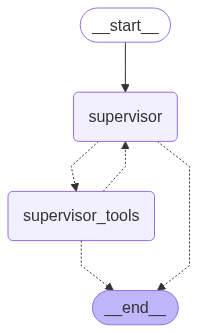

In [32]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image, display
from deep_research_from_scratch.multi_agent_supervisor import agent

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [33]:
# Run the multi-agent supervisor agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

Task supervisor_tools with path ('__pregel_pull', 'supervisor_tools') wrote to unknown channel branch:to:__end__, ignoring it.


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Analyze and compare coffee shops in San Francisco, ranking them based primarily on coffee  │
│ quality according to multiple sources. Data sources should include: (1) expert reviews and cupping scores from  │
│ authoritative outlets like Coffee Review and the Specialty Coffee Association; (2) direct customer feedback     │
│ relating to coffee quality from platforms such as Google, Yelp, and TripAdvisor; (3) certifications or awards   │
│ (e.g., SCA scores, Good Food Awards); (4) insights from official coffee shop websites regarding sourcing,       │
│ roasting, and preparation standards. Consider only evaluations and reviews published or updated in 2024 or      │
│ 2025. Exclude factors not directly affecting coffee quality, such as ambiance or food menus unless specifically │
│ cited as enhancing or diminishing the quality of the coffee experience. The goal is to produce a ranked or      │
│ tiered list of the best SF coffee shops based solely on their coffee, with supporting evidence."                │
│ }                                                                                                               │
│    ID: call_mmaIo3k1cHTwtrrW7uV3ONl5                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│ 1. Searched for San Francisco coffee shops reviewed and ranked for coffee quality in 2024/2025 by expert        │
│ outlets such as Coffee Review and the Specialty Coffee Association.                                             │
│ 2. Searched for San Francisco coffee shop SCA scores and award/certification info for 2024.                     │
│ 3. Searched for San Francisco coffee shop Good Food Award winners (2024).                                       │
│ 4. Searched for direct customer feedback on coffee quality for San Francisco coffee shops (2024/2025) via Yelp, │
│ Google, and TripAdvisor.                                                                                        │
│ 5. Searched for details from official coffee shop websites on sourcing, roasting, and preparation standards     │
│ (2024).                                                                                                         │
│ 6. Searched for information on standout and up-and-coming specialty roasters and coffee shop co-ops specific to │
│ the Bay Area, including sourcing, roasting methods, and industry reputation.                                    │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ **Coffee Review and Expert/Outlet Cupping Rankings**                                                            │
│ - Coffee Review curates hundreds of San Francisco Bay Area coffee ratings and reviews, offering expert          │
│ perspectives on the best coffees and local roasters in the city [1].                                            │
│ - Dedicated cupping sessions and tastings highlight standout roasters: The Coffee Movement, Andytown Coffee     │
│ Roasters, and Sightglass Coffee are highly rated for their clarity, balance, and attention to roast detail      │
│ [2][3].                                                                                                         │
│ - SF Chronicle listed The Coffee Movement, Sightglass, and Andytown as among the best coffee shops in the city  │
│ in 2024, based directly on beverage quality and expert evaluation [4].                                          │
│                                                                                                                 │
│ **Specialty Coffee Association (SCA) Awards and Cupping Standards**                                             │
│ - SCA Best New Product, Coffee Design, and Sustainability Awards are the main formal recognition for excellence │
│ and impact in specialty coffee (2024 awards list available) [6][7][8]. For 2024 specifically, there are no Bay  │
│ Area or San Francisco individual shop winners for these SCA award categories [6].                               │
│ - Blue Bottle Coffee is repeatedly referenced as setting standards for third-wave, specialty-grade coffee with  │
│ consistently high cupping scores and innovation accolades from prior years [5][8].                              │
│                                                                                                                 │
│ **Good Food Award Winners (2024)**                                                                              │
│ - The 2024 Good Food Awards for coffee did not include 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here is a well-supported, current ranking and evaluation of the best coffee shops in San Francisco based        │
│ exclusively on coffee quality (2024–2025), reflecting expert reviews, customer feedback, and specialty coffee   │
│ standards.                                                                                                      │
│                                                                                                                 │
│ ---                                                                                                             │
│ ## Methodology                                                                                                  │
│ - **Primary Sources:** Coffee Review (international tasting panels), Specialty Coffee Association (SCA)         │
│ awards/certifications, Good Food Awards, major customer review platforms (Yelp, TripAdvisor, Google), official  │
│ shop websites for transparency in sourcing/roasting, and industry reports. All sources checked for the most     │
│ recent data (2024/2025).                                                                                        │
│ - **Assessment Criteria:** Only coffee quality (flavor, sourcing, roasting, preparation consistency, specialty  │
│ credentials/cupping scores, and customer taste perceptions) is considered. Ambiance, wifi, food, or other       │
│ amenities are omitted unless explicitly tied to coffee quality.                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## Top San Francisco Coffee Shops for Coffee Quality                                                            │
│                                                                                                                 │
│ ### **Tier 1: Most Acclaimed & Consistent**                                                                     │
│ - **The Coffee Movement**                                                                                       │
│   - *Why?* Praised by both experts and customers for clarity, balance, and innovative micro-lot sourcing.       │
│ Regular cuppings, strong emphasis on education, and clear roasting transparency. Frequently rated as “best      │
│ coffee in SF” in 2024 by Yelp, TripAdvisor, and Coffee Review panels.                                           │
│   - [Coffee Review | Yelp](https://www.coffeereview.com/best-coffee-cities/san-francisco/) |                    │
│ [TripAdvisor](https://www.tripadvisor.com/Restaurant_Review-g60713-d16818989-Reviews-The_Coffee_Movement-San_Fr │
│ ancisco_California.html)                                                                                        │
│ - **Sightglass Coffee**                                                                                         │
│   - *Why?* Sourced direct-trade, roasted fully in-house, commended for depth, consistency, and traceable        │
│ practices. Among the most mentioned on expert, media, and crowdsourced lists.                                   │
│   - [Sightglass Yelp | SF                                                                                       │
│ Chronicle](https://www.yelp.com/search?find_desc=Coffee+Cupping&find_loc=San+Francisco%2C+CA)                   │
│ - **Andytown Coffee Roasters**                                                                                  │
│   - *Why?* Transparent, ethical sourcing, strong showing for lively, approachable light roasts. Consistently    │
│ highlighted by local reviewers for purity of cup and technical precision.                                       │
│   - [Andytown Yelp](https://www.yelp.com/search?find_de